In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import dvu
dvu.set_style()
import analyze_utils

cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

Load results

In [13]:
# dir_single_query = '/home/chansingh/mntv1/single_query_rough'
# dir_single_query = '/home/chansingh/mntv1/single_query_math_9_12'
dir_single_query = '/home/chansingh/mntv1/single_query_math_9_13'
r = analyze_utils.load_results_and_cache(dir_single_query, save_file='r.pkl')
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = analyze_utils.postprocess_results(r_single_query)


# dir_suffix_search = '/home/chansingh/mntv1/anli_rough' # note: anli_rought was missnamed
# dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_12' # note: anli_rought was missnamed
dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_13' # note: anli_rought was missnamed
r_suffix_search = analyze_utils.load_results_and_cache(dir_suffix_search, save_file='r.pkl')
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = analyze_utils.postprocess_results(r_suffix_search)

r = pd.concat((r_single_query, r_suffix_search)).sort_values('checkpoint')

100%|██████████| 425/425 [00:31<00:00, 13.69it/s]


Plot highly-summarized results

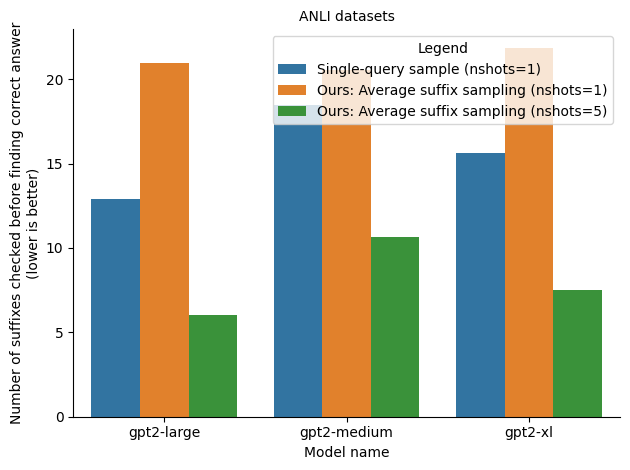

KeyError: "Columns not found: 'acc@3'"

In [ ]:
for metric_key in ['final_num_suffixes_checked', 'acc@3', 'acc@5', 'acc@10', 'acc@50', 'acc@150']:

    tab_single_query = analyze_utils.num_suffixes_checked_tab(r_single_query, metric_key=metric_key)
    tab_suffix_search = analyze_utils.num_suffixes_checked_tab(r_suffix_search, metric_key=metric_key)
    tab = pd.concat((tab_single_query, tab_suffix_search)).sort_values('checkpoint')
    tab['use_single_query'] = tab['use_single_query'].astype(bool)

    analyze_utils.plot_tab(tab, metric_key=metric_key, title='Math datasets')

# look at some of the tables

In [5]:
# cols_to_view = r_single_query.columns # cols_to_view
cols_to_view = [col for col in r_single_query.columns if col.startswith('final')]

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(['checkpoint', 'n_shots', 'use_single_query', 'task_name'])[cols_to_view].mean().round(2)
    display(rg[rg['final_answer_found'] < 1.0])

final_model_queries  \
checkpoint  n_shots use_single_query task_name                            
gpt2-large  1       0                fibonacci_one                60.50   
                    1                fibonacci_one                25.17   
            5       0                fibonacci_one                 4.00   
                    1                fibonacci_one                40.50   
gpt2-medium 1       1                fibonacci_one                36.62   
            5       0                subtract_two                 13.86   
                    1                fibonacci_one                59.15   
gpt2-xl     1       1                fibonacci_one                 9.35   

                                                    final_num_suffixes_checked  \
checkpoint  n_shots use_single_query task_name                                   
gpt2-large  1       0                fibonacci_one                      459.00   
                    1                fibonacci_one                      311.00   
            5       0                fibonacci_one                      208.00   
                    1                fibonacci_one                      342.00   
gpt2-medium 1       1                fibonacci_one                      427.92   
            5       0                subtract_two                        92.43   
                    1                fibonacci_one                      437.45   
gpt2-xl     1       1                fibonacci_one                      248.46   

                                                    final_answer_depth  \
checkpoint  n_shots use_single_query task_name                           
gpt2-large  1       0                fibonacci_one                3.00   
                    1                fibonacci_one                2.50   
            5       0                fibonacci_one                2.00   
                    1                fibonacci_one                2.50   
gpt2-medium 1       1                fibonacci_one                3.33   
            5       0                subtract_two                 2.00   
                    1                fibonacci_one                3.70   
gpt2-xl     1       1                fibonacci_one                2.35   

                                                    final_answer_found  
checkpoint  n_shots use_single_query task_name                          
gpt2-large  1       0                fibonacci_one                0.22  
                    1                fibonacci_one                0.22  
            5       0                fibonacci_one                0.11  
                    1                fibonacci_one                0.15  
gpt2-medium 1       1                fibonacci_one                0.89  
            5       0                subtract_two                 0.78  
                    1                fibonacci_one                0.74  
gpt2-xl     1       1                fibonacci_one                0.96

In [10]:
r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries']

template_num_init_string  use_single_query
0                         0                   1.0
                          1                   1.0
1                         0                   2.0
                          1                   2.0
2                         0                   2.0
                          1                   2.0
Name: final_model_queries, dtype: float64

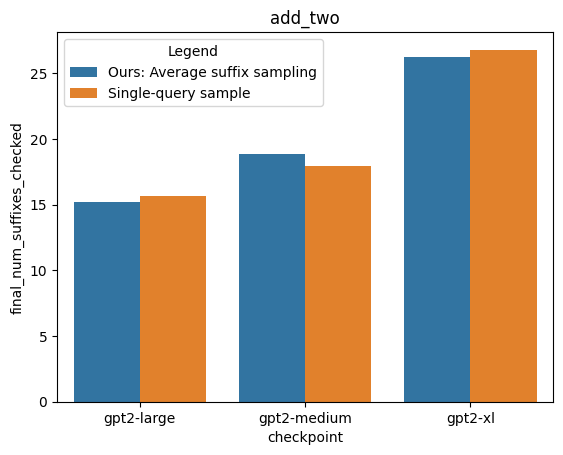

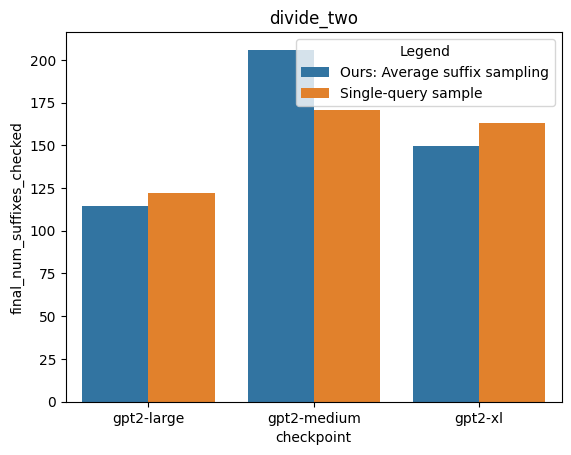

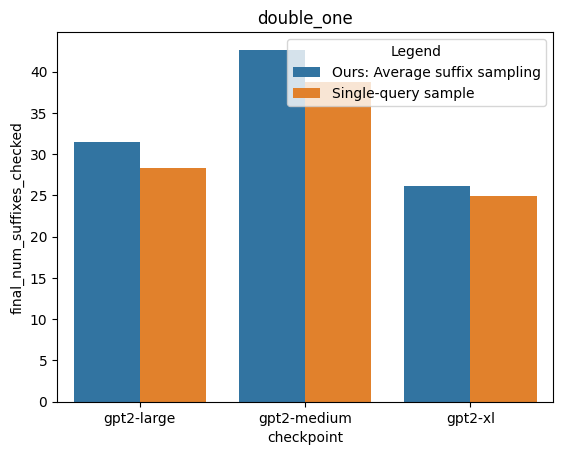

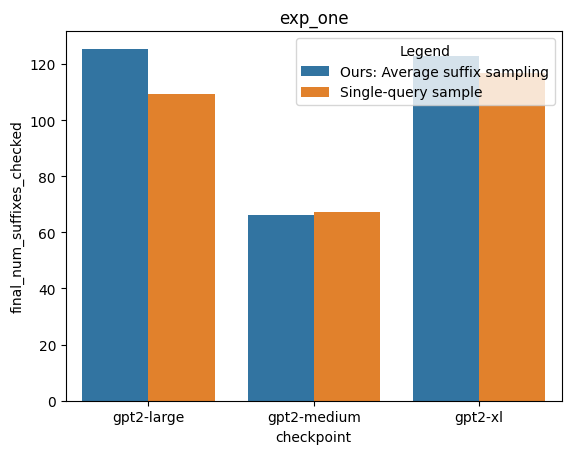

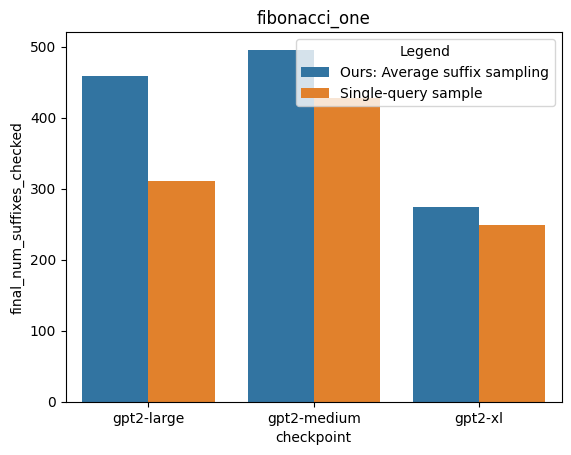

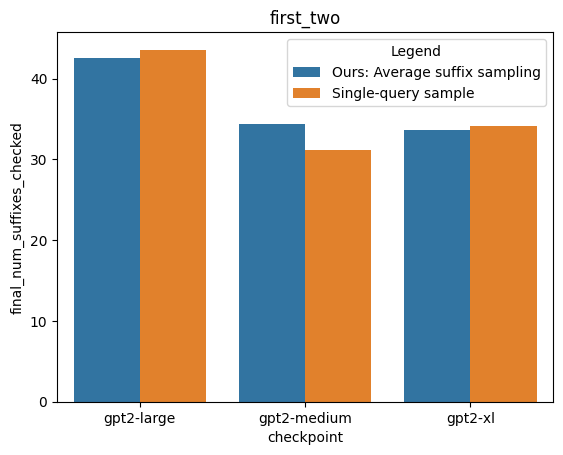

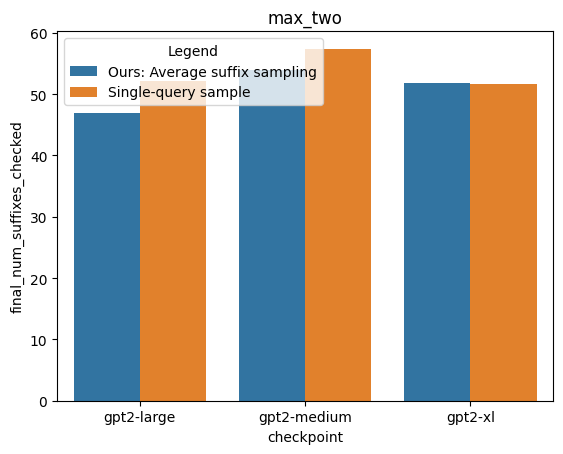

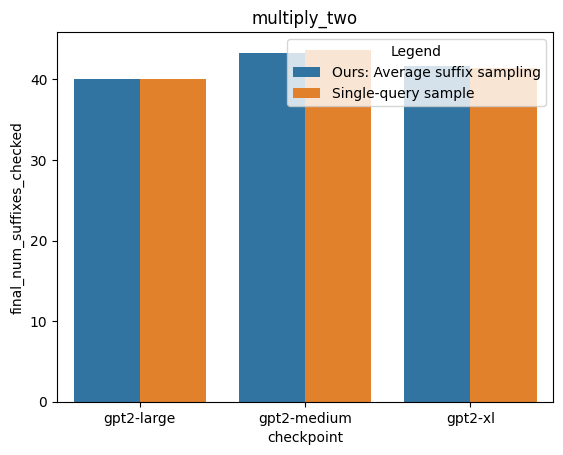

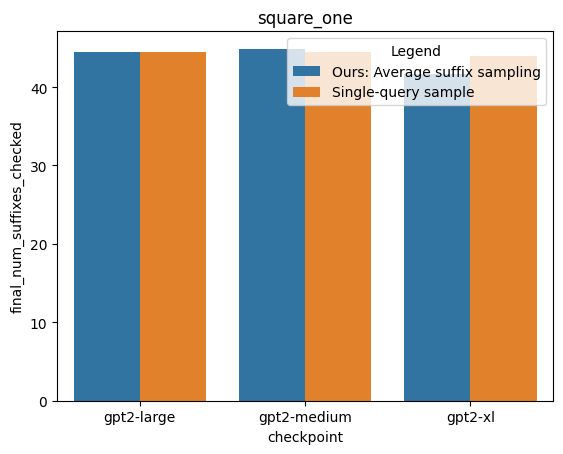

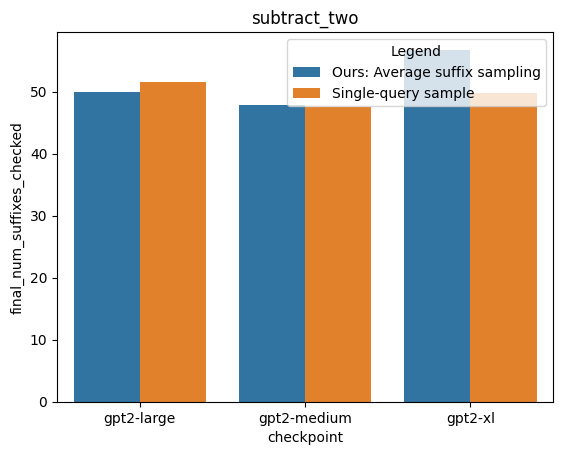

In [52]:
rp = rg.reset_index()
# display(rp)
rp['Legend'] = rp['use_single_query'].astype(bool).map(VALS)
rp = rp[rp['n_shots'] == 1]
for task_name in rp.task_name.unique():
    rpp = rp[rp.task_name == task_name]
    # display(rpp)
    plt.figure()
    plt.title(task_name)
    sns.barplot(x='checkpoint', y='final_num_suffixes_checked', hue='Legend', data=rpp) #data=tab[tab['n_shots'] == 1])

**break it down more**

In [8]:
r_single_query.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

final_model_queries  final_num_suffixes_checked  \
checkpoint  n_shots                                                    
gpt2-large  1                       2.35                       62.53   
            5                       2.49                       63.72   
            10                      1.35                       30.22   
gpt2-medium 1                       4.89                       90.95   
            5                       6.08                       85.98   
            10                      1.38                       33.12   
gpt2-xl     1                       2.60                       79.49   
            5                       3.17                       88.71   
            10                      1.51                       37.55   

                     final_answer_depth  final_answer_found  
checkpoint  n_shots                                          
gpt2-large  1                      1.64                0.92  
            5                      1.62                0.91  
            10                     1.35                1.00  
gpt2-medium 1                      1.69                0.99  
            5                      1.68                0.97  
            10                     1.36                1.00  
gpt2-xl     1                      1.63                1.00  
            5                      1.71                1.00  
            10                     1.42                1.00

In [9]:
r_single_query.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates

final_model_queries  \
checkpoint n_shots task_name                            
gpt2-large 1       add_two                       1.00   
                   divide_two                    2.89   
                   double_one                    1.33   
                   exp_one                       2.48   
                   fibonacci_one                25.17   
...                                               ...   
gpt2-xl    5       square_one                    1.67   
                   subtract_two                  1.67   
           10      add_two                       1.11   
                   divide_two                    8.00   
                   multiply_two                  1.67   

                                  final_num_suffixes_checked  \
checkpoint n_shots task_name                                   
gpt2-large 1       add_two                             15.70   
                   divide_two                         122.37   
                   double_one                          28.37   
                   exp_one                            109.33   
                   fibonacci_one                      311.00   
...                                                      ...   
gpt2-xl    5       square_one                          47.93   
                   subtract_two                        58.63   
           10      add_two                             26.44   
                   divide_two                         176.00   
                   multiply_two                        43.52   

                                  final_answer_depth  final_answer_found  
checkpoint n_shots task_name                                              
gpt2-large 1       add_two                      1.00                1.00  
                   divide_two                   2.00                1.00  
                   double_one                   1.33                1.00  
                   exp_one                      1.89                1.00  
                   fibonacci_one                2.50                0.22  
...                                              ...                 ...  
gpt2-xl    5       square_one                   1.67                1.00  
                   subtract_two                 1.67                1.00  
           10      add_two                      1.11                1.00  
                   divide_two                   3.00                1.00  
                   multiply_two                 1.67                1.00  

[69 rows x 4 columns]

In [10]:
r_suffix_search.groupby(['checkpoint', 'n_shots'])[cols_to_view].mean().round(2) # mean over templates, task_name

final_model_queries  final_num_suffixes_checked  \
checkpoint  n_shots                                                    
gpt2-large  1                       3.36                       66.86   
            5                       1.77                       57.74   
gpt2-medium 1                       7.31                      105.93   
            5                      14.17                      173.19   
gpt2-xl     1                       2.92                       82.90   
            5                       3.11                       89.16   

                     final_answer_depth  final_answer_found  
checkpoint  n_shots                                          
gpt2-large  1                      1.65                0.92  
            5                      1.60                0.91  
gpt2-medium 1                      1.79                1.00  
            5                      2.14                0.98  
gpt2-xl     1                      1.67                1.00  
            5                      1.72                1.00

,checkpoint,n_shots,final_num_suffixes_checked,use_single_query,Legend
0,gpt2-large,1,62.530120,True,Single-query sample (nshots=1)
1,gpt2-large,5,63.724696,True,Single-query sample (nshots=5)
2,gpt2-large,10,30.218182,True,Single-query sample (nshots=10)
0,gpt2-large,1,66.864198,False,Ours: Average suffix sampling (nshots=1)
1,gpt2-large,5,57.743902,False,Ours: Average suffix sampling (nshots=5)
3,gpt2-medium,1,90.947566,True,Single-query sample (nshots=1)
4,gpt2-medium,5,85.980989,True,Single-query sample (nshots=5)
5,gpt2-medium,10,33.125000,True,Single-query sample (nshots=10)
2,gpt2-medium,1,105.932584,False,Ours: Average suffix sampling (nshots=1)
3,gpt2-medium,5,173.193182,False,Ours: Average suffix sampling (nshots=5)


In [15]:
r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])[cols_to_view].mean().round(2) # mean over templates, task_name

final_model_queries  \
checkpoint  n_shots task_name                           
gpt2-large  1       add_two                      1.00   
                    divide_two                   2.78   
                    max_two                      1.57   
                    multiply_two                 1.67   
                    subtract_two                 1.67   
gpt2-medium 1       add_two                      1.00   
                    divide_two                   6.00   
                    first_two                    1.00   
                    max_two                      1.62   
                    multiply_two                 1.67   
                    subtract_two                 1.67   
gpt2-xl     1       add_two                      1.11   
                    divide_two                   3.89   
                    max_two                      1.67   
                    multiply_two                 1.67   
                    subtract_two                 1.67   

                                  final_num_suffixes_checked  \
checkpoint  n_shots task_name                                  
gpt2-large  1       add_two                            15.22   
                    divide_two                        114.22   
                    max_two                            46.86   
                    multiply_two                       40.00   
                    subtract_two                       50.00   
gpt2-medium 1       add_two                            18.89   
                    divide_two                        205.89   
                    first_two                           7.00   
                    max_two                            53.88   
                    multiply_two                       43.22   
                    subtract_two                       47.89   
gpt2-xl     1       add_two                            26.22   
                    divide_two                        149.78   
                    max_two                            51.89   
                    multiply_two                       41.67   
                    subtract_two                       56.78   

                                  final_answer_depth  final_answer_found  
checkpoint  n_shots task_name                                             
gpt2-large  1       add_two                     1.00                 1.0  
                    divide_two                  2.00                 1.0  
                    max_two                     1.57                 1.0  
                    multiply_two                1.67                 1.0  
                    subtract_two                1.67                 1.0  
gpt2-medium 1       add_two                     1.00                 1.0  
                    divide_two                  2.33                 1.0  
                    first_two                   1.00                 1.0  
                    max_two                     1.62                 1.0  
                    multiply_two                1.67                 1.0  
                    subtract_two                1.67                 1.0  
gpt2-xl     1       add_two                     1.11                 1.0  
                    divide_two                  2.11                 1.0  
                    max_two                     1.67                 1.0  
                    multiply_two                1.67                 1.0  
                    subtract_two                1.67                 1.0

In [9]:
rg = r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])
rg = rg[['final_model_queries','final_num_suffixes_checked']].mean().round(2) # mean over templates, task_name
print(rg.to_latex())

\begin{tabular}{lllrr}
\toprule
        &   &              &  final\_model\_queries &  final\_num\_suffixes\_checked \\
checkpoint & n\_shots & task\_name &                      &                             \\
\midrule
gpt2-large & 1 & add\_two &                 1.33 &                        5.67 \\
        &   & divide\_two &                 2.89 &                        8.67 \\
        &   & multiply\_two &                 3.89 &                       10.44 \\
gpt2-medium & 1 & add\_two &                 3.11 &                        8.44 \\
        &   & divide\_two &                 1.33 &                        5.44 \\
        &   & multiply\_two &                 1.33 &                        4.78 \\
gpt2-xl & 1 & add\_two &                 2.33 &                       12.11 \\
        &   & divide\_two &                 5.11 &                       18.78 \\
        &   & multiply\_two &                 1.33 &                        6.78 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2765084/1313215481.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rg.to_latex())
